### Agent Persistence, Streaming & Human in loop

In [1]:
# Search
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_ENDPOINT']="https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY']=os.getenv("LANGCHAIN_API_KEY", None)
os.environ['LANGCHAIN_PROJECT']="agentic_rag_bam"

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY", None)

In [2]:
## LLM

import warnings
warnings.filterwarnings("ignore")

# from dotenv import load_dotenv
# load_dotenv(override=True)

from genai import Client, Credentials
from genai.extensions.langchain import LangChainInterface
from genai.schema import (
    DecodingMethod,
    TextGenerationParameters,
)
from langchain_ibm import WatsonxLLM, ChatWatsonx
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams


def bam_model(model_id='meta-llama/llama-3-8b-instruct', decoding_method='greedy', max_new_tokens=1000, 
              min_new_tokens=1, temperature=0.1, top_k=50, top_p=1, repetition_penalty=1):

    if decoding_method == 'greedy':
        decoding_method = DecodingMethod.GREEDY
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            repetition_penalty=repetition_penalty
        )
    else:
        decoding_method = DecodingMethod.SAMPLE
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty
        )

    llm = LangChainInterface(
        model_id=model_id,
        client=Client(credentials=Credentials.from_env()),
        parameters=parameters,
    )

    return llm

def watsonx_model(model_id="mistralai/mixtral-8x7b-instruct-v01", decoding_method='greedy', max_new_tokens=1000, 
                  min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):
    params = {
        GenParams.DECODING_METHOD: decoding_method,
        GenParams.MIN_NEW_TOKENS: min_new_tokens,
        GenParams.MAX_NEW_TOKENS: max_new_tokens,
        GenParams.RANDOM_SEED: 42,
        GenParams.TEMPERATURE: temperature,
        GenParams.TOP_K: top_k,
        GenParams.TOP_P: top_p,
        GenParams.REPETITION_PENALTY: repetition_penalty
    }
    ibm_cloud_url = os.getenv("IBM_CLOUD_URL", None)
    project_id = os.getenv("PROJECT_ID", None)
    api_key = os.getenv("API_KEY")
    watsonx_llm = ChatWatsonx(
        model_id=model_id,
        url=ibm_cloud_url,
        apikey=api_key,
        project_id=project_id,
        params=params,
    )
    return watsonx_llm
# prompt = "Tell me about IBM."
# print(f"Prompt: {prompt}")

# local_llm = bam_model()
local_llm = watsonx_model()
# print(local_llm.invoke(prompt))


# local_llm = "llama3"
# model_tested = "meta-llama/llama-3-8b-instruct"
# metadata = f"Agentic-RAG, {model_tested}"

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
# from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [4]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [5]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [6]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        # human in loop
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

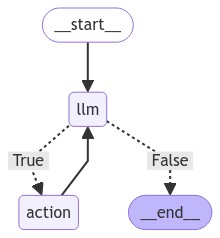

In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
abot = Agent(local_llm, [tool], system=prompt, checkpointer=memory)

from IPython.display import Image, display
display(Image(abot.graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="What is the weather in sf?")]

thread = {"configurable": {"thread_id": "1"}}

for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v['messages'])

{'messages': [HumanMessage(content='What is the weather in sf?', id='da3db521-7925-47c2-aca4-017a97f64221'), AIMessage(content='', additional_kwargs={'tool_calls': {'type': 'function', 'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'weather in sf'}}}}, response_metadata={'token_usage': {'generated_token_count': 71, 'input_token_count': 609}, 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'finish_reason': 'stop_sequence'}, id='run-46990dee-b5de-4b87-a55e-841adf00bebe-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': '1723006297.754', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})]}
[AIMessage(content='', additional_kwargs={'tool_calls': {'type': 'function', 'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'weather in sf'}}}}, response_metadata={'token_usage': {'generated_token_count': 71, 'input_token_c

In [9]:
from pprint import pprint
pprint(abot.graph.get_state(thread), indent=2, width=80, depth=None)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather in sf?', id='da3db521-7925-47c2-aca4-017a97f64221'), AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in sf'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-46990dee-b5de-4b87-a55e-841adf00bebe-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': '1723006297.754', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})]}, next=('action',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a6d-4817-6638-8001-28853f1b1e82'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={

In [10]:
abot.graph.get_state(thread).next

('action',)

#### continue after interrupt


In [11]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': '1723006297.754', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1723025919, \'localtime\': \'2024-08-07 03:18\'}, \'current\': {\'last_updated_epoch\': 1723025700, \'last_updated\': \'2024-08-07 03:15\', \'temp_c\': 13.3, \'temp_f\': 55.9, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 6.0, \'wind_kph\': 9.7, \'wind_degree\': 229, \'wind_dir\': \'SW\', \'pressure_mb\': 1014.0, \'pressure_in\': 29.94, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 85, \'cloud\': 3, \'feelslike_c\': 12.8, \'feelslike_f\': 

In [12]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather in sf?', id='da3db521-7925-47c2-aca4-017a97f64221'), AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in sf'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-46990dee-b5de-4b87-a55e-841adf00bebe-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': '1723006297.754', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680}), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \

In [13]:
abot.graph.get_state(thread).next

()

In [14]:
messages = [HumanMessage("Whats the weather in LA?")]

thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    # human in loop
    # _input = input("proceed?")
    # if _input != "y":
    #     print("aborting")
    #     break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='d624e2f1-54ed-4862-b4e4-b748b1a89b71'), AIMessage(content='', additional_kwargs={'tool_calls': {'type': 'function', 'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'weather in LA'}}}}, response_metadata={'token_usage': {'generated_token_count': 71, 'input_token_count': 609}, 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'finish_reason': 'stop_sequence'}, id='run-a6999344-1fe7-4176-952b-3a7ee7cf7606-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': '1723006305.965', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': {'type': 'function', 'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'weather in LA'}}}}, response_metadata={'token_usage': {'generated_token_count': 71, 'in

#### Modify State
Run until the interrupt and then modify the state.

In [15]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='51f7947c-5ba0-4a76-9c4a-4a8de8b46912'), AIMessage(content='', additional_kwargs={'tool_calls': {'type': 'function', 'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'weather in LA'}}}}, response_metadata={'token_usage': {'generated_token_count': 71, 'input_token_count': 609}, 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'finish_reason': 'stop_sequence'}, id='run-5728e00b-3edc-4fcd-afe7-22739abc3618-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': '1723006390.105', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})]}
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': {'type': 'function', 'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'weather in LA'}}}}, response_metadata={'token_usage': {'generated_token_count': 71, 'in

In [16]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='51f7947c-5ba0-4a76-9c4a-4a8de8b46912'), AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-5728e00b-3edc-4fcd-afe7-22739abc3618-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': '1723006390.105', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef54a70-b8f5-6fb4-8001-14f4d0513c72'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'t

In [17]:
current_values = abot.graph.get_state(thread)
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-5728e00b-3edc-4fcd-afe7-22739abc3618-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': '1723006390.105', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})

In [18]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in LA'},
  'id': '1723006390.105',
  'type': 'tool_call'}]

In [19]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Louisiana'},
  'id': _id}
]

In [20]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='51f7947c-5ba0-4a76-9c4a-4a8de8b46912'), AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-5728e00b-3edc-4fcd-afe7-22739abc3618-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': '1723006390.105'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})]}


{'configurable': {'thread_id': '3',
  'thread_ts': '1ef54a73-e858-6b50-8002-24230a88839b'}}

In [21]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='51f7947c-5ba0-4a76-9c4a-4a8de8b46912'), AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-5728e00b-3edc-4fcd-afe7-22739abc3618-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': '1723006390.105', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef54a73-e858-6b50-8002-24230a88839b'}}, metadata={'source': 'update', 'step': 2, 'writes': {'llm': {'messages': [HumanMessage(content='What

In [22]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': '1723006390.105', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.44, \'lon\': -91.06, \'tz_id\': \'America/Chicago\', \'localtime_epoch\': 1723026232, \'localtime\': \'2024-08-07 05:23\'}, \'current\': {\'last_updated_epoch\': 1723025700, \'last_updated\': \'2024-08-07 05:15\', \'temp_c\': 19.2, \'temp_f\': 66.6, \'is_day\': 0, \'condition\': {\'text\': \'Partly Cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/116.png\', \'code\': 1003}, \'wind_mph\': 8.5, \'wind_kph\': 13.7, \'wind_degree\': 354, \'wind_dir\': \'N\', \'pressure_mb\': 1014.0, \'pressure_in\': 29.96, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 79, \'cloud\': 46, \'feelslike_c\': 19.2, 

#### Time Travel

In [23]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='51f7947c-5ba0-4a76-9c4a-4a8de8b46912'), AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-5728e00b-3edc-4fcd-afe7-22739abc3618-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': '1723006390.105', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680}), ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Louisiana\', \'region\': \'Missouri\', \'country\': \'USA United States of America\', \'lat\': 39.44, \'lon\':

In [25]:
to_replay = states[-3]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='51f7947c-5ba0-4a76-9c4a-4a8de8b46912'), AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-5728e00b-3edc-4fcd-afe7-22739abc3618-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': '1723006390.105', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})]}, next=('action',), config={'configurable': {'thread_id': '3', 'thread_ts': '1ef54a70-b8f5-6fb4-8001-14f4d0513c72'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'llm': {'messages': [AIMessage(content='', additional_kwargs={'t

In [27]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': '1723006390.105', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.05, \'lon\': -118.24, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1723026351, \'localtime\': \'2024-08-07 03:25\'}, \'current\': {\'last_updated_epoch\': 1723025700, \'last_updated\': \'2024-08-07 03:15\', \'temp_c\': 23.3, \'temp_f\': 74.0, \'is_day\': 0, \'condition\': {\'text\': \'Clear\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/113.png\', \'code\': 1000}, \'wind_mph\': 4.5, \'wind_kph\': 7.2, \'wind_degree\': 167, \'wind_dir\': \'SSE\', \'pressure_mb\': 1014.0, \'pressure_in\': 29.95, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 57, \'cloud\': 3, \'feelslike_c\': 25.1, \'feelslike_f\': 7

#### Go back in time and edit


In [28]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in LA, accuweather'},
  'id': _id}]

In [29]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='51f7947c-5ba0-4a76-9c4a-4a8de8b46912'), AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-5728e00b-3edc-4fcd-afe7-22739abc3618-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': '1723006390.105'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680})]}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': '1723006390.105', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'co

#### Add message to a state at a given time

In [30]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search_results_json",
    content="54 degree celcius",
)]}

In [31]:
branch_and_add = abot.graph.update_state(
    to_replay.config, 
    state_update, 
    as_node="action")

In [32]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='51f7947c-5ba0-4a76-9c4a-4a8de8b46912'), AIMessage(content='', additional_kwargs={'tool_calls': {'function': {'arguments': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json'}, 'type': 'function'}}, response_metadata={'finish_reason': 'stop_sequence', 'model_name': 'mistralai/mixtral-8x7b-instruct-v01', 'system_fingerprint': '', 'token_usage': {'generated_token_count': 71, 'input_token_count': 609}}, id='run-5728e00b-3edc-4fcd-afe7-22739abc3618-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': '1723006390.105', 'type': 'tool_call'}], usage_metadata={'input_tokens': 609, 'output_tokens': 71, 'total_tokens': 680}), ToolMessage(content='54 degree celcius', name='tavily_search_results_json', id='d0b38db2-6ea7-47a4-ad0e-9e888322d62f', tool_call_id='1723006390.105'), AIMessage(content='You are a smart research assistant. Use the search engine to look up information. Y

### Extra
- Graph to get more insight into controlling the state of the memory

In [34]:
class AgentState(TypedDict):
    lnode: str  # last node
    scratch: str  # a scratchpad
    count: Annotated[int, operator.add]  # a counter that is incremented each step

In [35]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,
           }
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
           }

In [36]:
def should_continue(state):
    return state["count"] < 3


# node1 -> node2 -> node1 ... breaks after count reaches to 3

In [37]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges(
    "Node2", 
    should_continue, 
    {
        True: "Node1", 
        False: END
    }
)
builder.set_entry_point("Node1")

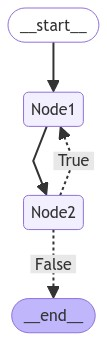

In [38]:
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
thread = {"configurable": {"thread_id": str(1)}}
graph.invoke({"count":0, "scratch":"hi"},thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

In [40]:
# current state
graph.get_state(thread)

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c342-66fe-8004-13816a73540a'}}, metadata={'source': 'loop', 'step': 4, 'writes': {'Node2': {'count': 1, 'lnode': 'node_2'}}}, parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c33d-6c1c-8003-6565c7c73482'}})

In [41]:
# state history
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c342-66fe-8004-13816a73540a'}}, metadata={'source': 'loop', 'step': 4, 'writes': {'Node2': {'count': 1, 'lnode': 'node_2'}}}, parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c33d-6c1c-8003-6565c7c73482'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c33d-6c1c-8003-6565c7c73482'}}, metadata={'source': 'loop', 'step': 3, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c339-66a8-8002-3bdfa9ce68fe'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 2}, next=('Node1',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c339-66a8-8002-3bdfa9ce68fe'}}, metadata={'source': 'loop', 'step': 2, 'writes':

In [42]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c342-66fe-8004-13816a73540a'}} 4
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c33d-6c1c-8003-6565c7c73482'}} 3
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c339-66a8-8002-3bdfa9ce68fe'}} 2
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c332-6bf0-8001-f432e89b56eb'}} 1
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c32c-655c-8000-15ece73d67e8'}} 0
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c329-66ea-bfff-3d1a073db090'}} 0


In [43]:
states[-3]

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef54a8c-c332-6bf0-8001-f432e89b56eb'}}

In [44]:
graph.get_state(states[-3])

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c332-6bf0-8001-f432e89b56eb'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c32c-655c-8000-15ece73d67e8'}})

In [45]:
## go back in time

graph.invoke(None, states[-3])

node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

In [46]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8f-b630-6cb0-8004-ca8c70060959'}} 4
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8f-b62c-6bce-8003-daf9dac14f99'}} 3
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8f-b629-61a4-8002-56be406bf682'}} 2
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c342-66fe-8004-13816a73540a'}} 4
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c33d-6c1c-8003-6565c7c73482'}} 3
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c339-66a8-8002-3bdfa9ce68fe'}} 2
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c332-6bf0-8001-f432e89b56eb'}} 1
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c32c-655c-8000-15ece73d67e8'}} 0
{'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8c-c329-66ea-bfff-3d1a073db090'}} 0


In [47]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8f-b630-6cb0-8004-ca8c70060959'}}, metadata={'source': 'loop', 'step': 4, 'writes': {'Node2': {'count': 1, 'lnode': 'node_2'}}}, parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8f-b62c-6bce-8003-daf9dac14f99'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8f-b62c-6bce-8003-daf9dac14f99'}}, metadata={'source': 'loop', 'step': 3, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, parent_config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8f-b629-61a4-8002-56be406bf682'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 2}, next=('Node1',), config={'configurable': {'thread_id': '1', 'thread_ts': '1ef54a8f-b629-61a4-8002-56be406bf682'}}, metadata={'source': 'loop', 'step': 2, 'writes':

In [48]:
## modify state
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count":0, "scratch":"hi"},thread2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

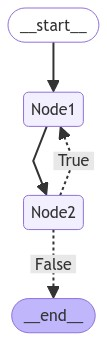

In [50]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [51]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])   

{'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-4975-602e-8004-008fb04554a4'}} 4
{'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-496d-6d2e-8003-11f88d449f8a'}} 3
{'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-496a-607a-8002-e59d12ef088b'}} 2
{'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-4962-6e06-8001-690313847f7f'}} 1
{'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-495b-67c8-8000-67d511f0be94'}} 0
{'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-4956-6462-bfff-bcd1fbbdd9ef'}} 0


In [52]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-4962-6e06-8001-690313847f7f'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-495b-67c8-8000-67d511f0be94'}})

In [53]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-4962-6e06-8001-690313847f7f'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-495b-67c8-8000-67d511f0be94'}})

In [54]:
graph.update_state(thread2,save_state.values)

{'configurable': {'thread_id': '2',
  'thread_ts': '1ef54a94-bf91-605c-8005-51f8c1fe9e32'}}

In [55]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a94-bf91-605c-8005-51f8c1fe9e32'}}, metadata={'source': 'update', 'step': 5, 'writes': {'Node2': {'count': -3, 'lnode': 'node_1', 'scratch': 'hello'}}}, parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-4975-602e-8004-008fb04554a4'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-4975-602e-8004-008fb04554a4'}}, metadata={'source': 'loop', 'step': 4, 'writes': {'Node2': {'count': 1, 'lnode': 'node_2'}}}, parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-496d-6d2e-8003-11f88d449f8a'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-496d-6d2e-8003-11f88d449f8a'}}, metadata={'source': 'l

In [56]:
# try again with as_node

graph.update_state(thread2,save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'thread_ts': '1ef54a95-7351-6236-8006-14f8364d3816'}}

In [57]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a95-7351-6236-8006-14f8364d3816'}}, metadata={'source': 'update', 'step': 6, 'writes': {'Node1': {'count': -3, 'lnode': 'node_1', 'scratch': 'hello'}}}, parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a94-bf91-605c-8005-51f8c1fe9e32'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a94-bf91-605c-8005-51f8c1fe9e32'}}, metadata={'source': 'update', 'step': 5, 'writes': {'Node2': {'count': -3, 'lnode': 'node_1', 'scratch': 'hello'}}}, parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-4975-602e-8004-008fb04554a4'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a91-4975-602e-8004-008fb04554a4

In [58]:
graph.invoke(None,thread2)

node2, count:-2
node1, count:-1
node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

In [59]:
for state in graph.get_state_history(thread2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a96-4e44-6230-800b-151e38a2f101'}}, metadata={'source': 'loop', 'step': 11, 'writes': {'Node2': {'count': 1, 'lnode': 'node_2'}}}, parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a96-4e3f-606e-800a-e6a6a2c99abc'}}) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a96-4e3f-606e-800a-e6a6a2c99abc'}}, metadata={'source': 'loop', 'step': 10, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, parent_config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a96-4e3b-614e-8009-126bae95bf52'}}) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1ef54a96-4e3b-614e-8009-126bae95bf52'}}, metadata={'source': 'loop', 'step': 9